In [1]:
%matplotlib inline
# %matplotlib qt
# import mpld3
# mpld3.enable_notebook() # seems to just freeze the stuff a bit
# import matplotlib
# matplotlib.use('nbagg') # also slow AF

In [2]:
from __future__ import print_function, division
import os, sys
import numpy as np, scipy as sp
import scipy.io
import scipy.signal as signal, scipy.fftpack as ftpk, scipy.integrate as integrate, scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib

original_dir = os.getcwd()

In [3]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2
SR=400

In [4]:
import pywt
# import pyhht

In [5]:
from imp import reload
import auxfilter
import glob

In [6]:
os.chdir(original_dir + '/..')
# os.chdir('/home/mike/venvs/ml/ml/py')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics

/home/mm/py/kaggle


In [7]:
reload(plotstuff)
reload(dataio)

<module 'eegkaggle.dio.dataio' from '/home/mm/py/kaggle/eegkaggle/dio/dataio.py'>

In [8]:
matplotlib.style.use('ggplot')

In [9]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = slong

Functions

In [10]:
# this needs to be here because...reasons?
def pltcwt(plt, my_cwt, widths, realize=None):
    hi = np.max(widths)
    lo = np.min(widths)
    if realize == 'abs':
        my_cwt = np.abs(my_cwt)
    elif realize == 'ang':
        my_cwt = np.angle(my_cwt)
    plt.imshow(my_cwt, extent=[-1, 1, hi, lo], cmap='seismic', aspect='auto',
               vmax=abs(my_cwt).max(), vmin=-abs(my_cwt).max())


def plt_easycwt(plt, sig, widths):
    my_cwt = signal.cwt(sig, signal.ricker, widths)
    pltcwt(plt, my_cwt, widths)

In [11]:
def ridiculous_log_transform(data, featsize=1024, fs=400, smoothing_cutoff=1, hard_cutoff=100, log_low_cut=-5):
    """ This function returns a distorted version (x-axis log-transformed) of the fourier transform of the signal.
    My hope is with this approach is that it results in a more normally-distributed looking vector, which should lead
    to less weirdness in the NNs later on. At least that is my hope. I've been informed by my signals teacher that
    taking the log of the y of a signal is bad, and warping x is worse! But oh well, we shall see if it works. 
    """
    # FFT and magnitude
    ftsig = ftpk.fft(data, axis=0) 
    ftsig_a = np.abs(ftsig[:len(ftsig)*hard_cutoff//fs])
    # Smooth it with low pass and downsample. Low pass may not be necessary since resample does appropriate
    # pre-filtering
    ftsig_f = auxfilter.butterfilt(ftsig_a, smoothing_cutoff, fs)
    ftsig_r = signal.resample(ftsig_f, featsize)

    # Ok, now the weird bit. Take the existing x-domain and create an interpolation image of it
    t_rs = np.linspace(0.0001, hard_cutoff, featsize)
    fn_ftsig_rs = interpolate.Akima1DInterpolator(t_rs, ftsig_r)
    # And now map an exponential domain, thereby creating a higher density of points around the main freq
    log_ftsig = fn_ftsig_rs(np.exp(np.linspace(log_low_cut, np.log(hard_cutoff), featsize)))
    return log_ftsig

Data loading section

In [12]:
data = dataio.get_matlab_eeg_data_ary('eegkaggle/sampledata/1_120_0.mat')
data1 = dataio.get_matlab_eeg_data_ary('eegkaggle/sampledata/1_120_1.mat')

In [13]:
# plt.plot(data)
dc = np.mean(data, axis=0)
print(dc)
print(np.mean(dc))

[ -7.08007803e-07  -2.08321121e-03   1.08009405e-01  -8.67582858e-02
   8.85919780e-02  -1.06979884e-01  -1.97200142e-02  -2.28913069e-01
  -1.26555145e-01  -2.41018683e-01  -2.16518492e-01   2.02205926e-01
   4.64643717e-01   2.88321555e-01   2.73539573e-01   5.68727888e-02]
0.0283523


In [14]:
# plt.plot(data1)
dc1 = np.mean(data1, axis=0)
print(dc1)
print(np.mean(dc1))

[ -5.31005867e-07   6.96682930e-03   2.67259758e-02  -5.09116193e-03
   2.31781155e-02  -2.13048942e-02  -5.46713872e-03  -4.51788679e-02
  -2.03990117e-02  -3.61289755e-02  -5.09039015e-02   4.05215025e-02
   8.69080871e-02   5.73382601e-02   3.43673527e-02   2.42187898e-03]
0.0058721


In [15]:
brief = data[:SR*120]
brief.shape

(48000, 16)

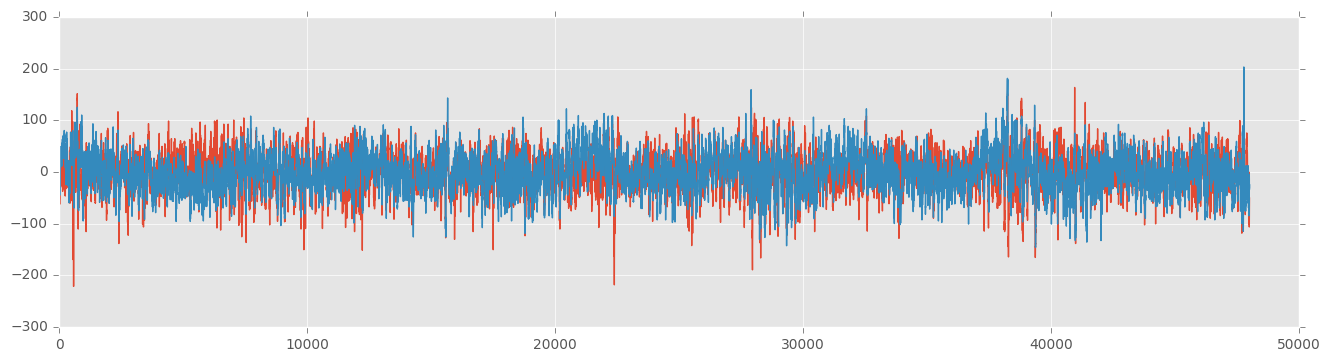

In [16]:
plt.plot(brief[:,:2])

In [17]:
eeg1 = brief[:,0]
eeg2 = brief[:,1]

In [18]:
lo, hi = 1, 16
nbins = 32
widths = np.linspace(lo, hi, nbins)**2

In [19]:
data.shape

(240000, 16)

In [20]:
l = len(data)

In [21]:
sig = data[:, 0]
fsig = ftpk.fft(data, axis=0)
fsig1 = ftpk.fft(data1, axis=0)

t = np.linspace(0, 400, len(fsig))

fsig.shape


(240000, 16)

In [22]:
t = np.linspace(0, 400, len(fsig))
# plt.plot(t, fsig)

In [23]:
fsig_a = np.abs(fsig[:l/4])
fsig_a1 = np.abs(fsig1[:l/4])

# plt.plot(fsig_a)

/home/mm/py/ml/tf/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/home/mm/py/ml/tf/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [24]:
cutoff = 1
fsig_f = auxfilter.butterfilt(fsig_a, cutoff, SR)
fsig_f1 = auxfilter.butterfilt(fsig_a1, cutoff, SR)

# plt.plot(t[:l/12], fsig_f[:l/12])

In [25]:
# plt.plot(np.log(fsig_a[:l/8]))

In [26]:
# plt.plot((t[:l/4])**1, fsig_f[:l/4], c='b')
# plt.plot((t[:l/4])**1, fsig_f1[:l/4], c='r')

# plt.xlim(-6,6)
print()

In [38]:
ns_rs = 1024
t_rs = np.linspace(0.0001, 100, ns_rs)
fsig_rs = signal.resample(fsig_f, ns_rs)
# plt.plot(np.log(t_rs), fsig_rs)
# plt.xlim(-4,4)

In [37]:
fn_fsig_rs = interpolate.Akima1DInterpolator(t_rs, fsig_rs)

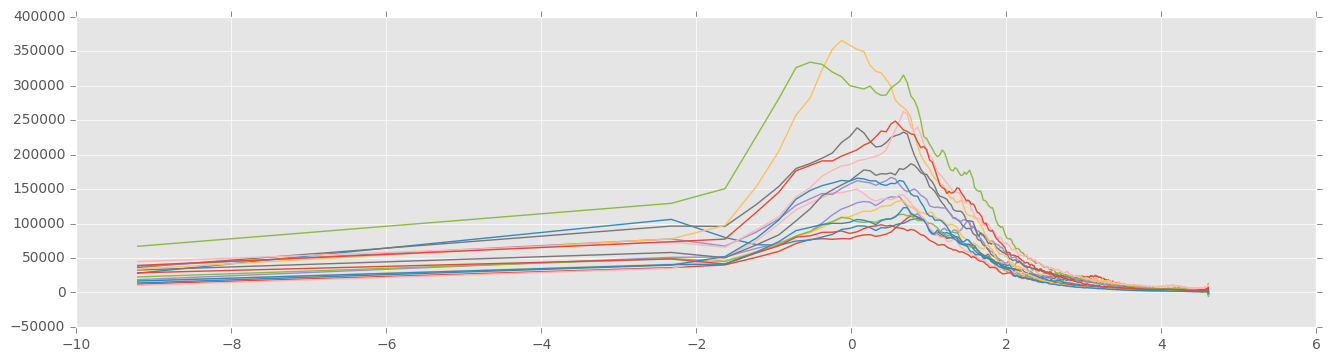

In [29]:
# plt.plot(np.log(t_rs), fn_fsig_rs(t_rs))
print()

1024


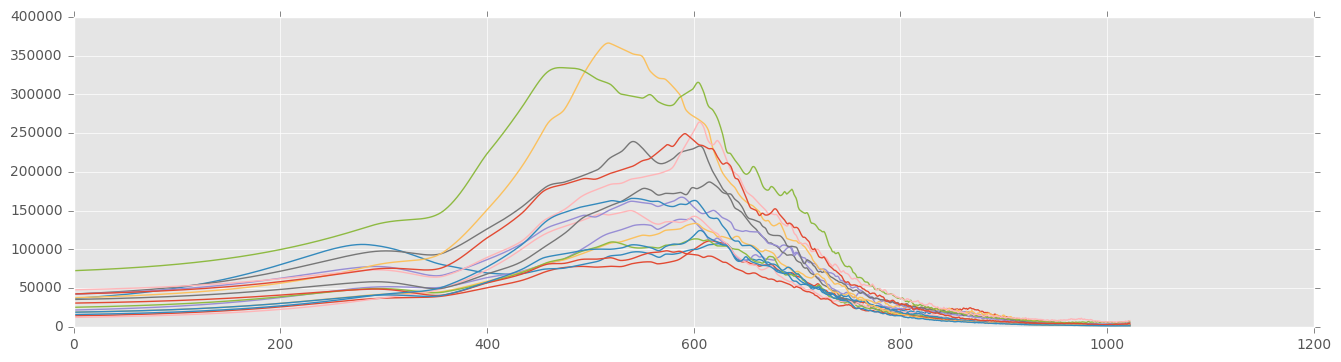

In [30]:
log_fsig_rs = fn_fsig_rs(np.exp(np.linspace(-5,np.log(100),ns_rs)))
plt.plot(log_fsig_rs)
print(len(log_fsig_rs))

In [31]:
ridic = ridiculous_log_transform(data)

In [35]:
# plt.plot(ridic)
print('And it works!')

And it works!


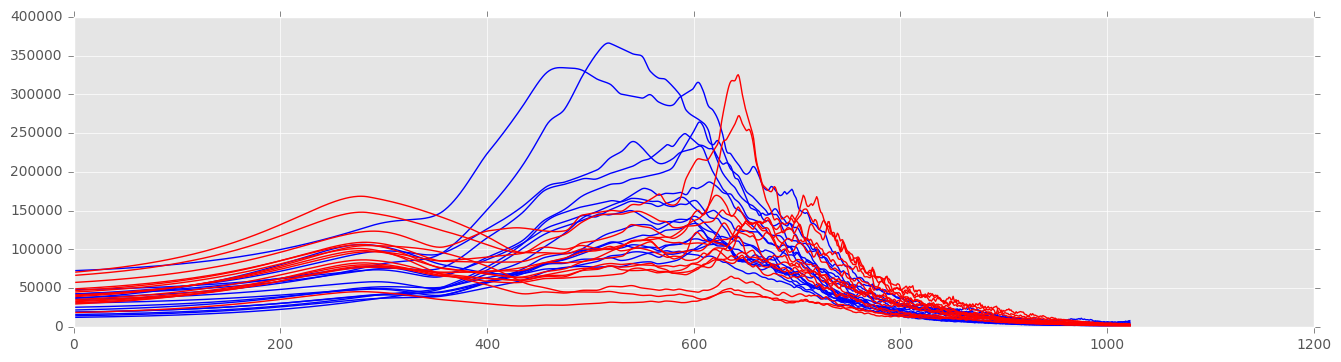

In [33]:
plt.plot(ridic, 'b')
plt.plot(ridiculous_log_transform(data1)[:,:3], 'r')
plt.plot(ridiculous_log_transform(data1)[:,4:16]*2, 'r')

# plt.plot(data1)
print('')

In [34]:
+


SyntaxError: invalid syntax (<ipython-input-34-c30dba8197a1>, line 1)